## **Maestría en Inteligencia Artificial Aplicada**
### **Curso: Análisis de grandes volúmenes de datos (Gpo 10)**
#### Tecnológico de Monterrey
####Profesor Tutor:  Profr. Adolfo Centeno

### **Avance de proyecto 1: Sistema de Recomendación**
### **Alumnos:**
* Fernando Acevedo Ortegate - A01794022
* Aldo Daniel Nava Barrios - A01333185
* Rafael Alejandro Cocotle Brand - A00787544


In [1]:
# Las librerías y paquetes que vamos a usar.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Vamos a usar la librería Surprise que ofrece implementaciones eficientes
# de varios algoritmos de filtrado colaborativo, incluyendo SVD y KNN
%pip install scikit-surprise
from scipy.sparse import csr_matrix
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split


In [2]:
# Cargamos la información de los archivos
from google.colab import drive
drive.mount('/content/drive')
movies = pd.read_csv('/content/drive/MyDrive/Big Data/Modulo 2/Semana 4/movies.csv', sep=',', header='infer')
ratings = pd.read_csv('/content/drive/MyDrive/Big Data/Modulo 2/Semana 4/ratings.csv', sep=',', header='infer')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


# **Análisis descriptivo y preprocesamiento de los datos:**

Para este proyecto no necesitamos toda la información de las tablas, hay columnas que podemos remover.
Para el caso de ratings podemos remover el timestamp y del set de datos movies, solo necesitaremos el id y el título.

Después de seleccionar las columnas que vamos a usar, juntaremos todo en un solo data frame.

In [5]:
#Eliminamos la columna "genres" de movies
movies.drop('genres', axis=1, inplace=True)
movies.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [6]:
#Eliminamos la columna de timestamp de ratings
ratings.drop('timestamp', axis=1, inplace=True)
ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [7]:
#Juntamos la información que necesitamos en un solo DataFrame
movie_ratings = pd.merge(ratings, movies, on='movieId')
movie_ratings.head()

,userId,movieId,rating,title
0,1,1,4.0,Toy Story (1995)
1,5,1,4.0,Toy Story (1995)
2,7,1,4.5,Toy Story (1995)
3,15,1,2.5,Toy Story (1995)
4,17,1,4.5,Toy Story (1995)


In [8]:
movie_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100836 non-null  int64  
 1   movieId  100836 non-null  int64  
 2   rating   100836 non-null  float64
 3   title    100836 non-null  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 3.1+ MB


*   Podemos observar que nuestros datos no tienen valores nulos.
*   Tenemos 3 variables numéricas y una categórica



In [9]:
movie_ratings.describe().T

,count,mean,std,min,25%,50%,75%,max
userId,100836.0,326.127564,182.618491,1.0,177.0,325.0,477.0,610.0
movieId,100836.0,19435.295718,35530.987199,1.0,1199.0,2991.0,8122.0,193609.0
rating,100836.0,3.501557,1.042529,0.5,3.0,3.5,4.0,5.0


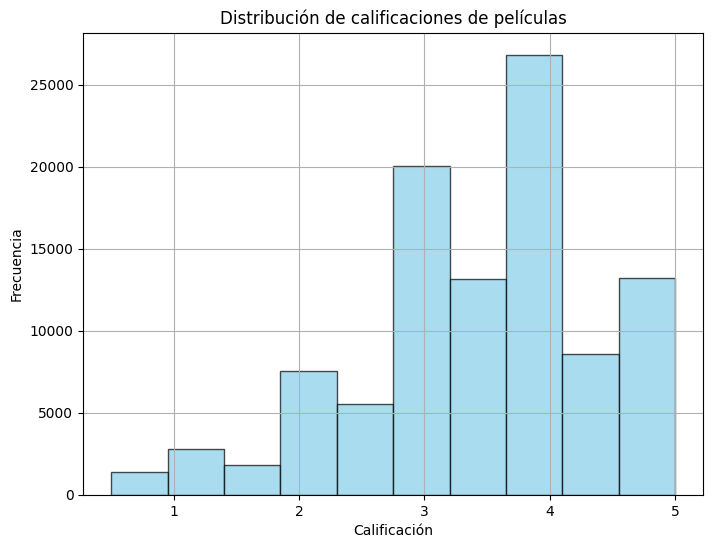

In [10]:
# Ver la distribución de las calificaciones de las películas
plt.figure(figsize=(8, 6))
plt.hist(movie_ratings['rating'], bins=10, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribución de calificaciones de películas')
plt.xlabel('Calificación')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

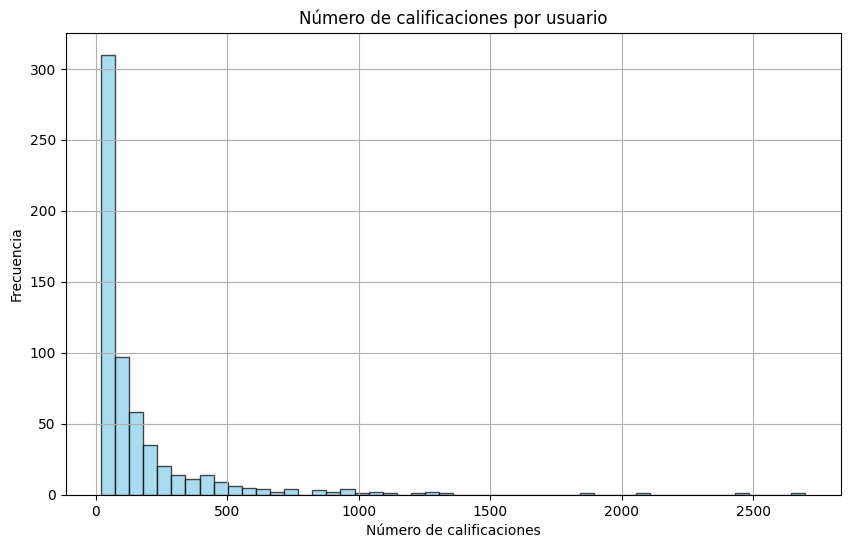

In [11]:
# Calcular el número de calificaciones por usuario
ratings_per_user = movie_ratings.groupby('userId')['rating'].count()

# Ver el número de calificaciones por usuario
plt.figure(figsize=(10, 6))
plt.hist(ratings_per_user, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Número de calificaciones por usuario')
plt.xlabel('Número de calificaciones')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

In [12]:
ratings_per_user

userId
1       232
2        29
3        39
4       216
5        44
       ... 
606    1115
607     187
608     831
609      37
610    1302
Name: rating, Length: 610, dtype: int64

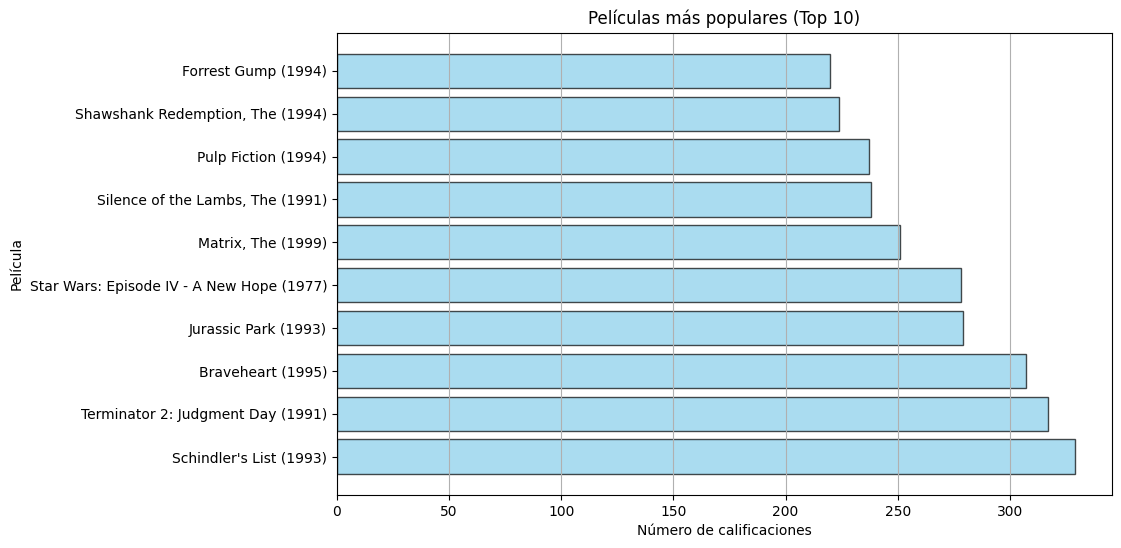

In [13]:
# Calcular el número de calificaciones por película
ratings_per_movie = movie_ratings.groupby('title')['rating'].count().sort_values(ascending=False)

# Ver la popularidad de las películas
plt.figure(figsize=(10, 6))
plt.barh(ratings_per_movie.head(10).index[::-1], ratings_per_movie.head(10), color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Películas más populares (Top 10)')
plt.xlabel('Número de calificaciones')
plt.ylabel('Película')
plt.grid(axis='x')
plt.show()

# **Desarrollo del modelo para el sistema de recomendación**

In [14]:
# Convertimos nuestro Pandas DataFrame en un Surprise dataset
reader = Reader(rating_scale=(0.5, 5.0))
surprise_dataset = Dataset.load_from_df(movie_ratings[['userId', 'movieId', 'rating']], reader)

# Dividimos los datos en conjunto de entrenamiento y de prueba (70-30)
train, test = train_test_split(surprise_dataset, test_size=0.2, random_state=5)

# Definimos que nuestro modelo será SVD
modelo = SVD()

# Entrenamos el modelo con el conjunto de entrenamiento
modelo.fit(train)

In [15]:
# Predicciones en el conjunto test
predicciones = modelo.test(test)

# Calculamos el error cuadrático medio
mse = accuracy.mse(predicciones)
print("Error cuadrático medio (MSE):", mse)

MSE: 0.7571
Error cuadrático medio (MSE): 0.7571474565084401


In [16]:
# Vamos a ver las recomendaciones para un usuario

# Para esta prueba se usará el id = 6
usuario = 6

# Obtenemos la lista de películas que ya se calificaron por el usuario
peliculas_calificadas = set(movie_ratings[movie_ratings['userId'] == usuario]['movieId'])
# Obtenemos la lista de todas las películas
todas_peliculas = set(movie_ratings['movieId'])

# Ahora podemos encontrar los películas que el usuario no ha visto
peliculas_a_recomendar = todas_peliculas - peliculas_calificadas

# Obtener las predicciones
predicciones = [(movie_id, modelo.predict(usuario, movie_id).est) for movie_id in peliculas_a_recomendar]

top_10 = sorted(range(len(predicciones)), key=lambda i: predicciones[i], reverse=True)[:10]

# Como solo tenemos los ids, vamos a obtener los nombres de las peliculas
top_10_titulo = movies[movies['movieId'].isin(top_10)]['title'].tolist()

top_10_titulo


['Lightning in a Bottle (2004)',
 'Undertow (2004)',
 'Saw (2004)',
 'Ray (2004)',
 'Birth (2004)',
 'Incredibles, The (2004)',
 'Callas Forever (2002)']

Lo anterior también se podría convertir en una función que reciba el id del usuario